In [ ]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd

# Needed for some plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
#Reading the data ()

In [ ]:
raw_cells_tumor2 = sc.read("/scratch/fatemeh.nasrabadi/importsnt/THESIS_FINAL/10Samples/FINALIZED_GEX_INTEGRATED/Tumor_row_FINAL_afteratac8121.h5ad")

In [ ]:
raw_cells_tumor2

AnnData object with n_obs × n_vars = 8121 × 36601
    obs: 'site', 'patient', 'patientzone', 'source'

# Pseudobulk with grouping cells

In [ ]:
all_data = raw_cells_tumor2

In [ ]:
import numpy as np
import pandas as pd

# Copy obs
obs = all_data.obs.copy()

# Function to assign group numbers
def assign_groups(df, group_size=40):
    df = df.copy()
    df['group'] = np.repeat(np.arange(len(df) // group_size + 1), group_size)[:len(df)]
    return df

# Split by site
core_cells = obs[obs['site'] == 'Core'].copy()
peri_cells = obs[obs['site'] == 'Peri'].copy()

# Assign groups
peri_cells = assign_groups(peri_cells)
num_peri_groups = peri_cells['group'].nunique()

core_cells = assign_groups(core_cells)
core_cells['group'] += num_peri_groups  # offset

# Assign groups directly to all_data.obs
all_data.obs['group'] = np.nan  # initialize with NaN
all_data.obs.loc[peri_cells.index, 'group'] = peri_cells['group']
all_data.obs.loc[core_cells.index, 'group'] = core_cells['group']


In [ ]:
all_data.obs['group']

AATCATCCATGTGGGA-1_BTROHT06_Peri      0.0
ACCCGTAAGAACCTAC-1_BTROHT06_Peri      0.0
AGTATAGCATTGTGTG-1_BTROHT06_Peri      0.0
ATATGCTCATCCCGCT-1_BTROHT06_Peri      0.0
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri      0.0
                                    ...  
TTTGGTGCAAGACTCC-1_BTROHT06_Core    203.0
TTTGTCTAGAGAGCCG-1_BTROHT06_Core    203.0
TTTGTGTTCCAATTAG-1_BTROHT06_Core    203.0
TTTGTTGGTAATGACT-1_BTROHT06_Core    203.0
TTTGTTGGTTCATCTA-1_BTROHT06_Core    203.0
Name: group, Length: 8121, dtype: float64

In [ ]:
print(all_data.obs['group'].isna().sum())

0


In [ ]:
all_data.obs["group"].value_counts()

group
202.0    40
0.0      40
1.0      40
187.0    40
188.0    40
         ..
8.0      40
9.0      40
10.0     40
13.0     34
203.0     7
Name: count, Length: 204, dtype: int64

In [ ]:
# Store raw counts in layers
all_data.X = np.round(all_data.X)
all_data.layers['counts'] = all_data.X.copy()

In [ ]:
# Normalize and log-transform
sc.pp.normalize_total(all_data, target_sum=1e4)
sc.pp.log1p(all_data)
all_data.layers['normalized'] = all_data.X

/home/fatemeh.nasrabadi/anaconda3/envs/new_scenv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:438: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


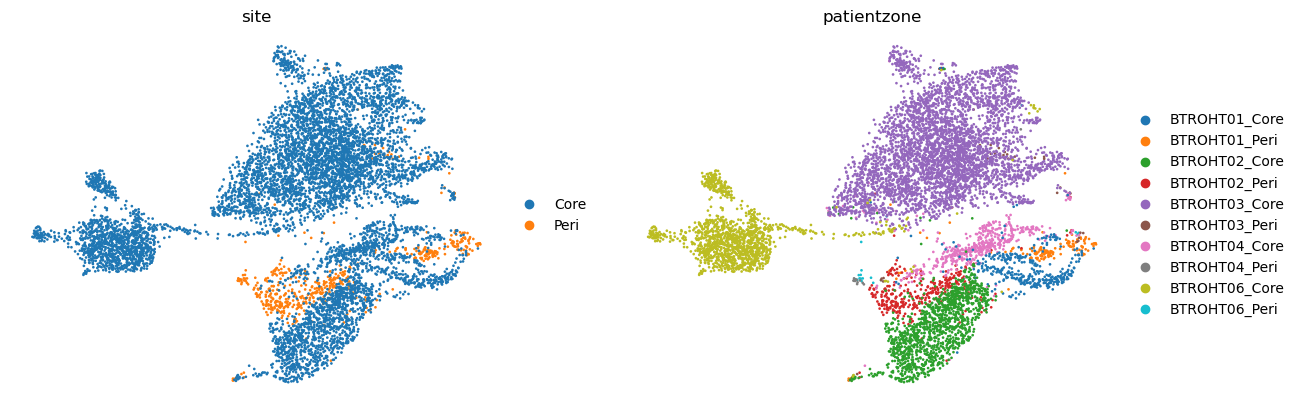

In [ ]:
# Identify highly variable genes
sc.pp.highly_variable_genes(all_data, batch_key='site')

# Scale the data
sc.pp.scale(all_data, max_value=10)

# Generate PCA features
sc.tl.pca(all_data, svd_solver='arpack', use_highly_variable=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(all_data)

# Generate UMAP features
sc.tl.umap(all_data)

# Visualize
sc.pl.umap(all_data, color=['site','patientzone'], frameon=False)

In [ ]:
all_data

AnnData object with n_obs × n_vars = 8121 × 36601
    obs: 'site', 'patient', 'patientzone', 'source', 'group'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'site_colors', 'patientzone_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

In [ ]:
len(all_data.obs['group'].value_counts())

204

In [ ]:
all_data.obs['group']=all_data.obs['group'].astype('str')

In [ ]:
all_data.layers['counts'].toarray()[50, 50:]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
# Get filtered pseudo-bulk profile
newpseu = dc.get_pseudobulk(
    all_data,
    sample_col='site',
    groups_col='group',
    layer='counts',
    mode='sum',
    #min_cells=,
    #min_counts=1000
)
newpseu

AnnData object with n_obs × n_vars = 203 × 32154
    obs: 'site', 'group', 'psbulk_n_cells', 'psbulk_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    layers: 'psbulk_props'

In [ ]:
newpseu.X

array([[ 2.,  4.,  0., ..., 25.,  5., 47.],
       [ 2.,  2.,  0., ..., 15.,  3., 24.],
       [ 1.,  1.,  0., ..., 14., 27., 28.],
       ...,
       [ 0.,  0.,  0., ..., 14.,  6., 21.],
       [ 0.,  0.,  0., ...,  8.,  2., 17.],
       [ 1.,  0.,  0., ...,  8.,  9., 30.]], dtype=float32)

In [ ]:
newpseu.obs["group"]

Peri_0.0        0.0
Peri_1.0        1.0
Peri_10.0      10.0
Core_100.0    100.0
Core_101.0    101.0
              ...  
Core_95.0      95.0
Core_96.0      96.0
Core_97.0      97.0
Core_98.0      98.0
Core_99.0      99.0
Name: group, Length: 203, dtype: object

In [ ]:
# Store raw counts in layers
newpseu.layers['counts'] = newpseu.X.copy()

# Normalize, scale and compute PCA
sc.pp.normalize_total(newpseu, target_sum=1e4)
sc.pp.log1p(newpseu)
sc.pp.scale(newpseu, max_value=10)
sc.tl.pca(newpseu)

# Return raw counts to X
dc.swap_layer(newpseu, 'counts', X_layer_key=None, inplace=True)


In [ ]:
newpseu.obs['site'].value_counts()

site
Core    189
Peri     14
Name: count, dtype: int64

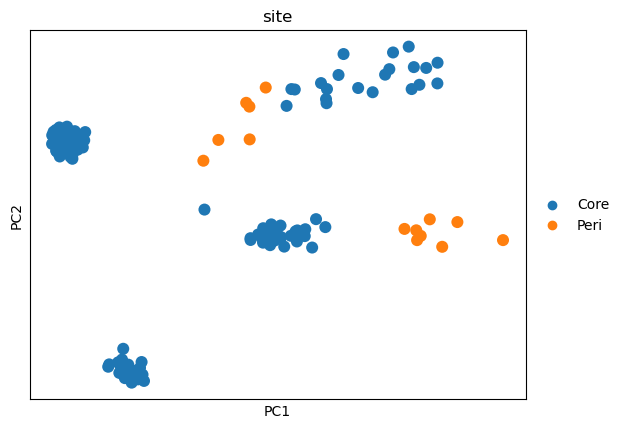

In [ ]:
sc.pl.pca(newpseu, color=['site'], ncols=5, size=300)

In [ ]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [ ]:
inference = DefaultInference(n_cpus=1)
dds = DeseqDataSet(adata=newpseu, design_factors='site',ref_level=['site', 'Core'], refit_cooks=True, inference=inference)

/tmp/ipykernel_3197116/3305763938.py:2: DeprecationWarning: ref_level is deprecated and no longer has any effect. It will beremoved in a future release.
  dds = DeseqDataSet(adata=newpseu, design_factors='site',ref_level=['site', 'Core'], refit_cooks=True, inference=inference)
/tmp/ipykernel_3197116/3305763938.py:2: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(adata=newpseu, design_factors='site',ref_level=['site', 'Core'], refit_cooks=True, inference=inference)


In [ ]:
 # Compute LFCs
dds.deseq2()
dds


Fitting size factors...
... done in 0.14 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 26.43 seconds.

Fitting dispersion trend curve...
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 40.72 seconds.

Fitting LFCs...
... done in 20.16 seconds.

Calculating cook's distance...
... done in 0.47 seconds.

Replacing 48 outlier genes.

Fitting dispersions...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 0.06 seconds.

Fitting LFCs...
... done in 0.04 seconds.



AnnData object with n_obs × n_vars = 203 × 32154
    obs: 'site', 'group', 'psbulk_n_cells', 'psbulk_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'pca', 'site_colors', 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'X_pca', 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: 'PCs', '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'psbulk_props', 'counts', 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks'

In [ ]:
stat = DeseqStats(dds, contrast=["site","Peri", "Core"], inference=inference, alpha=0.05, independent_filter=True)
stat.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: site Peri vs Core
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.794397        0.701350  0.472156  1.485420  0.137433  0.264447
A1BG-AS1   0.788584        0.345394  0.525121  0.657743  0.510704  0.672981
A1CF       0.050508       -0.037149  3.371154 -0.011020  0.991208       NaN
A2M       17.142514       -0.357427  0.212045 -1.685616  0.091870  0.194245
A2M-AS1    0.271774        0.847181  0.709974  1.193257  0.232769  0.391578
...             ...             ...       ...       ...       ...       ...
ZXDC      16.720614        0.077602  0.148321  0.523204  0.600832  0.747531
ZYG11A     0.131845       -0.003958  1.505953 -0.002628  0.997903       NaN
ZYG11B    11.552506        0.296442  0.123994  2.390776  0.016813  0.051313
ZYX        9.777191        1.353866  0.283405  4.777147  0.000002  0.000024
ZZEF1     24.311018        0.273624  0.119274  2.294067  0.021787  0.063042

[32154 rows x 6 columns]


... done in 3.79 seconds.



In [ ]:
stat.results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,0.794397,0.701350,0.472156,1.485420,0.137433,0.264447
A1BG-AS1,0.788584,0.345394,0.525121,0.657743,0.510704,0.672981
A1CF,0.050508,-0.037149,3.371154,-0.011020,0.991208,NaN
A2M,17.142514,-0.357427,0.212045,-1.685616,0.091870,0.194245
A2M-AS1,0.271774,0.847181,0.709974,1.193257,0.232769,0.391578
...,...,...,...,...,...,...
ZXDC,16.720614,0.077602,0.148321,0.523204,0.600832,0.747531
ZYG11A,0.131845,-0.003958,1.505953,-0.002628,0.997903,NaN
ZYG11B,11.552506,0.296442,0.123994,2.390776,0.016813,0.051313
ZYX,9.777191,1.353866,0.283405,4.777147,0.000002,0.000024


In [ ]:
# Extract results
results_df = stat.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,0.794397,0.701350,0.472156,1.485420,0.137433,0.264447
A1BG-AS1,0.788584,0.345394,0.525121,0.657743,0.510704,0.672981
A1CF,0.050508,-0.037149,3.371154,-0.011020,0.991208,NaN
A2M,17.142514,-0.357427,0.212045,-1.685616,0.091870,0.194245
A2M-AS1,0.271774,0.847181,0.709974,1.193257,0.232769,0.391578
...,...,...,...,...,...,...
ZXDC,16.720614,0.077602,0.148321,0.523204,0.600832,0.747531
ZYG11A,0.131845,-0.003958,1.505953,-0.002628,0.997903,NaN
ZYG11B,11.552506,0.296442,0.123994,2.390776,0.016813,0.051313
ZYX,9.777191,1.353866,0.283405,4.777147,0.000002,0.000024


In [ ]:
!pwd

/home/fatemeh.nasrabadi/ROVIGO_congas/final/gex_aggregation


In [ ]:
results_df.to_csv("/scratch/fatemeh.nasrabadi/importsnt/THESIS_FINAL/10Samples/FINALIZED_GEX_INTEGRATED/DGE/DESEQ2_row8121.csv", index=True)

In [ ]:
significant_genes = results_df[results_df['padj'] < 0.05]
print(significant_genes)

          baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A2ML1     0.621603        2.515720  0.487951  5.155677  2.527161e-07   
AARS      7.392607        0.576136  0.172883  3.332529  8.606048e-04   
AARSD1    8.047400        0.550575  0.181598  3.031830  2.430763e-03   
AASS     45.851328        0.302145  0.101554  2.975226  2.927724e-03   
AATK     14.977495        2.410194  0.413872  5.823528  5.761831e-09   
...            ...             ...       ...       ...           ...   
ZSCAN23   3.362617       -1.947744  0.457861 -4.254009  2.099766e-05   
ZSCAN5A   8.636725        0.540863  0.185440  2.916652  3.538101e-03   
ZSWIM6   72.285496        0.418593  0.086683  4.829017  1.372084e-06   
ZWILCH    4.186012       -0.675685  0.254995 -2.649796  8.054039e-03   
ZYX       9.777191        1.353866  0.283405  4.777147  1.777994e-06   

                 padj  
A2ML1    4.562052e-06  
AARS     4.587726e-03  
AARSD1   1.076868e-02  
AASS     1.255537e-02  
AATK     1.6516

In [ ]:
#for enrichment just significants and log cheched

significant_genes_padlog = results_df[
    (results_df['padj'] < 0.05) &
    (results_df['log2FoldChange'].abs() > 1)
]



In [ ]:
significant_genes_padlog

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2ML1,0.621603,2.515720,0.487951,5.155677,2.527161e-07,4.562052e-06
AATK,14.977495,2.410194,0.413872,5.823528,5.761831e-09,1.651696e-07
ABCA10,2.317523,1.172452,0.329152,3.562036,3.679898e-04,2.257802e-03
ABCA13,2.082815,3.546778,0.434219,8.168182,3.130717e-16,5.974399e-14
ABCA2,13.245236,2.772918,0.410308,6.758136,1.397786e-11,7.837055e-10
...,...,...,...,...,...,...
ZNHIT1,3.428321,1.277161,0.204324,6.250679,4.086709e-10,1.561221e-08
ZNRD1,1.267514,1.046201,0.326255,3.206701,1.342666e-03,6.618887e-03
ZRANB2-AS1,1.926915,-1.956548,0.605984,-3.228714,1.243483e-03,6.216764e-03
ZSCAN23,3.362617,-1.947744,0.457861,-4.254009,2.099766e-05,1.984255e-04


In [ ]:
significant_genes_padlog.to_csv("/scratch/fatemeh.nasrabadi/importsnt/THESIS_FINAL/10Samples/FINALIZED_GEX_INTEGRATED/DGE/DESEQ2_metacells_tumorcells_siglog1padj8121.csv", index=True)

In [ ]:
!pwd

/home/fatemeh.nasrabadi/ROVIGO_congas/final/gex_aggregation


In [ ]:
# Filter significant genes (adjusted p < 0.05)
sig = significant_genes_padlog[significant_genes_padlog["padj"] < 0.05]

# Count upregulated genes in peri (log2FoldChange > 0)
peri_up = (sig["log2FoldChange"] > 0).sum()

# Count upregulated genes in core (log2FoldChange < 0)
core_up = (sig["log2FoldChange"] < 0).sum()

print(f"Upregulated in peri (positive log2FoldChange): {peri_up}")
print(f"Upregulated in core (negative log2FoldChange): {core_up}")


Upregulated in peri (positive log2FoldChange): 2579
Upregulated in core (negative log2FoldChange): 750


In [ ]:
!pwd

/home/fatemeh.nasrabadi/ROVIGO_congas/final/gex_aggregation


In [ ]:
significant_genes_padlog.to_csv("/home/fatemeh.nasrabadi/DESEQ2_metacells_tumorcells_siglog1padj8121.csv", index=True)

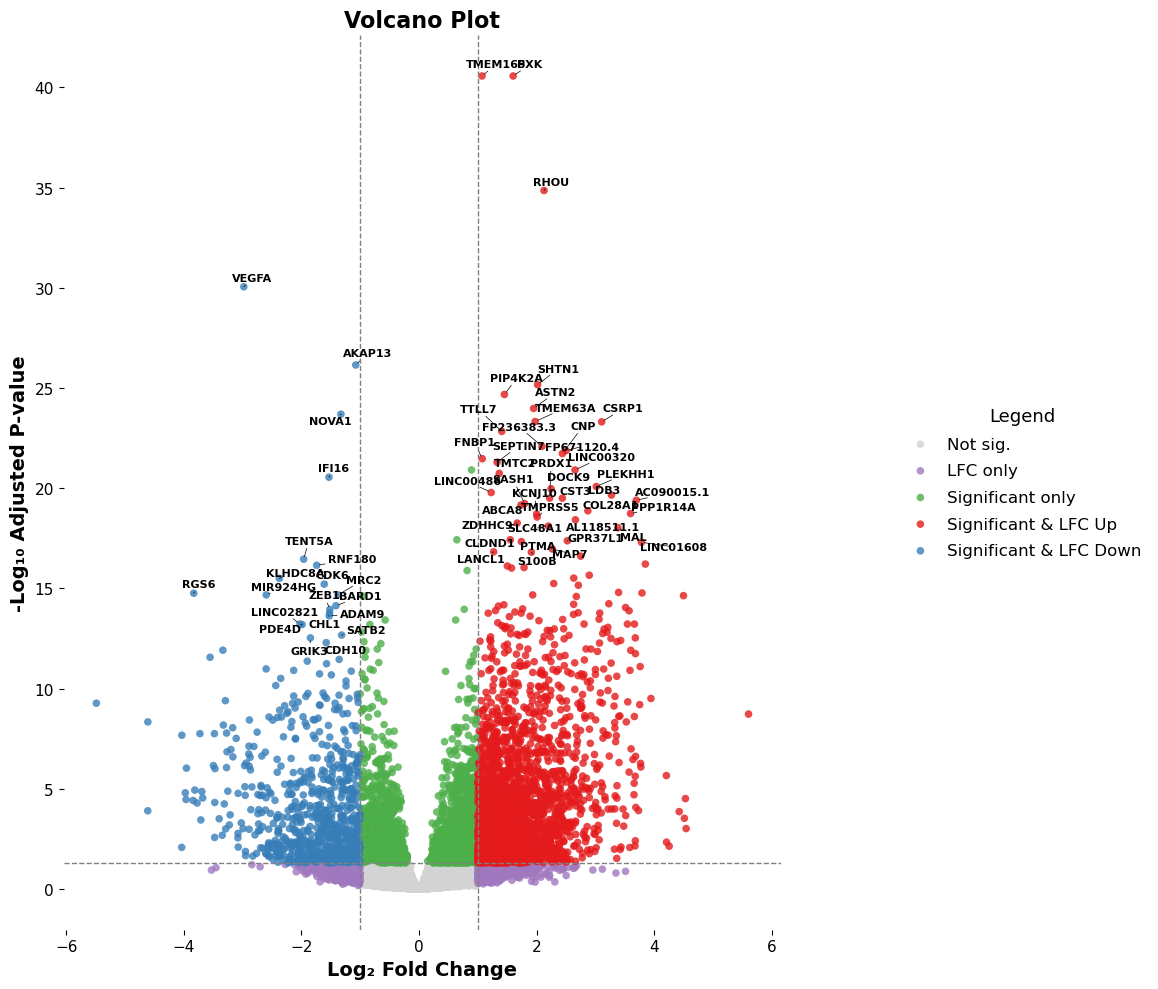

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text

# Copy and prepare data
df = results_df.copy()
df = df.dropna(subset=['padj'])
df['-log10(padj)'] = -np.log10(df['padj'])

# Categorize points
df['category'] = 'Not sig.'
df.loc[(df['padj'] < 0.05) & (df['log2FoldChange'] >= 1), 'category'] = 'Significant & LFC Up'
df.loc[(df['padj'] < 0.05) & (df['log2FoldChange'] <= -1), 'category'] = 'Significant & LFC Down'
df.loc[(df['padj'] < 0.05) & (df['category'] == 'Not sig.'), 'category'] = 'Significant only'
df.loc[(df['padj'] >= 0.05) & (abs(df['log2FoldChange']) >= 1), 'category'] = 'LFC only'

# Define color mapping
color_map = {
    'Not sig.': '#D3D3D3',               # light gray
    'LFC only': '#a078bf',               # light purple
    'Significant only': '#4daf4a',       # green
    'Significant & LFC Up': '#e41a1c',   # red
    'Significant & LFC Down': '#377eb8'  # blue
}

# Setup plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot each category
for category, color in color_map.items():
    subset = df[df['category'] == category]
    ax.scatter(
        subset['log2FoldChange'],
        subset['-log10(padj)'],
        label=category,
        color=color,
        s=30,
        alpha=0.8,
        edgecolor='none'
    )

# Threshold lines
ax.axhline(-np.log10(0.05), color='gray', linestyle='--', linewidth=1)
ax.axvline(1, color='gray', linestyle='--', linewidth=1)
ax.axvline(-1, color='gray', linestyle='--', linewidth=1)

# Top genes (more from positive side, bold text)
top_up = df[df['category'] == 'Significant & LFC Up'].nlargest(40, '-log10(padj)')
top_down = df[df['category'] == 'Significant & LFC Down'].nlargest(20, '-log10(padj)')

# Add text with adjustText
texts = []
for _, row in pd.concat([top_up, top_down]).iterrows():
    texts.append(ax.text(
        row['log2FoldChange'], row['-log10(padj)'], row.name,
        fontsize=8, weight='bold', ha='center', va='bottom'
    ))

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

# Labels and title
ax.set_xlabel("Log₂ Fold Change", fontsize=14, weight='bold')
ax.set_ylabel("-Log₁₀ Adjusted P-value", fontsize=14, weight='bold')
ax.set_title("Volcano Plot", fontsize=16, weight='bold')

# Custom Legend
ax.legend(
    title='Legend',
    title_fontsize=13,
    fontsize=12,
    loc='center left',
    bbox_to_anchor=(1.15, 0.5),
    frameon=False,
    labelspacing=0.7,
    handletextpad=0.6,
    borderaxespad=0.5
)

# Clean plot styling
ax.tick_params(labelsize=11)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


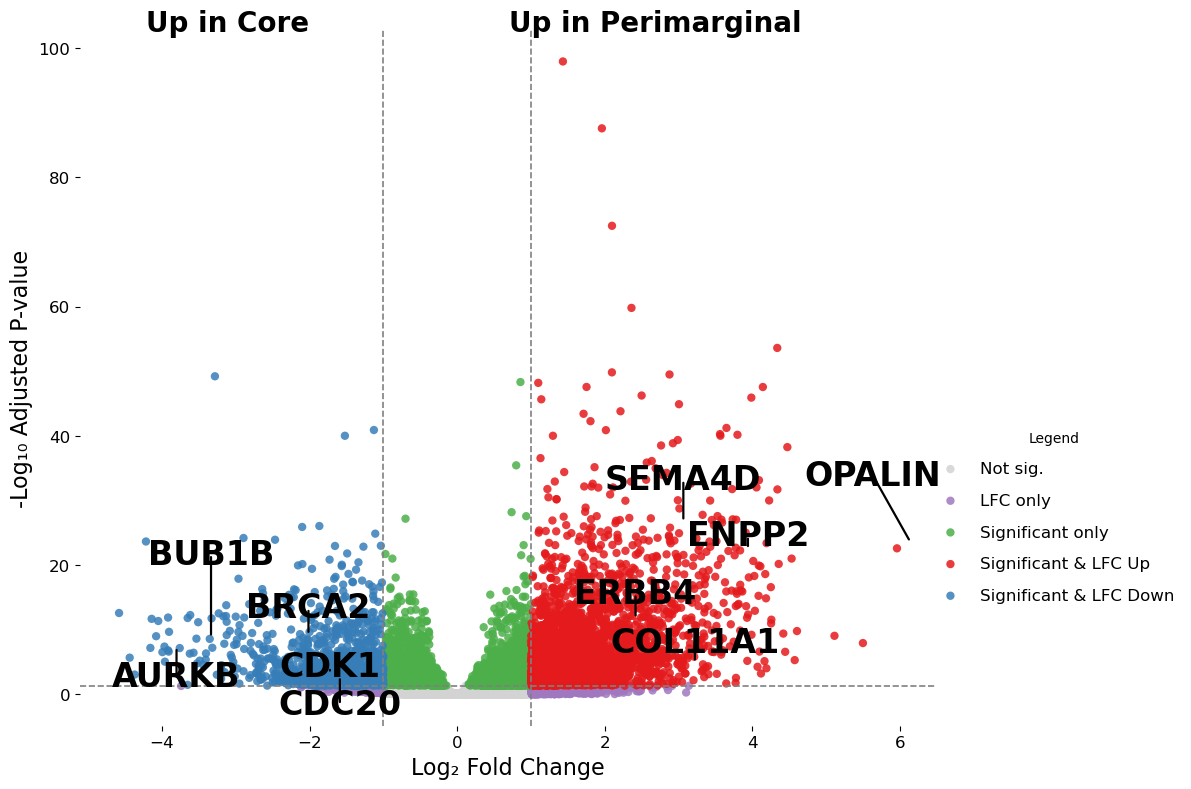

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text

# ========================
# Prep data
# ========================
df = results_df.copy()
df = df.dropna(subset=['padj', 'log2FoldChange'])
df['-log10(padj)'] = -np.log10(df['padj'])

# If gene symbols are in a column (e.g. "gene") instead of the index, uncomment:
# df.index = df['gene']

# ========================
# Categorize points
# ========================
df['category'] = 'Not sig.'
df.loc[(df['padj'] < 0.05) & (df['log2FoldChange'] >= 1),  'category'] = 'Significant & LFC Up'
df.loc[(df['padj'] < 0.05) & (df['log2FoldChange'] <= -1), 'category'] = 'Significant & LFC Down'
df.loc[(df['padj'] < 0.05) & (df['category'] == 'Not sig.'), 'category'] = 'Significant only'
df.loc[(df['padj'] >= 0.05) & (df['log2FoldChange'].abs() >= 1), 'category'] = 'LFC only'

color_map = {
    'Not sig.': '#D3D3D3',
    'LFC only': '#a078bf',
    'Significant only': '#4daf4a',
    'Significant & LFC Up': '#e41a1c',
    'Significant & LFC Down': '#377eb8'
}

# ========================
# Your curated 5 + 5 genes
# ========================
core_genes = {"CDK1","BUB1B","CDC20","AURKB","BRCA2"}
#peri_genes = {"ATP5F1B","NDUFS7","RPS6","SOD1","NGF"}
peri_genes = {"ENPP2", "ERBB4", "SEMA4D", "COL11A1", "OPALIN"}

core_present = [g for g in core_genes if g in df.index]
peri_present = [g for g in peri_genes if g in df.index]
missing_core = sorted(core_genes - set(core_present))
missing_peri  = sorted(peri_genes - set(peri_present))
if missing_core or missing_peri:
    print("Missing genes ->",
          ("CORE: " + ", ".join(missing_core)) if missing_core else "",
          (" | PERI: " + ", ".join(missing_peri)) if missing_peri else "")

# ========================
# Plot (bigger for poster)
# ========================
plt.close('all')
fig, ax = plt.subplots(figsize=(12, 8))  # bigger canvas

# Background points by category
for cat, color in color_map.items():
    sub = df[df['category'] == cat]
    ax.scatter(
        sub['log2FoldChange'], sub['-log10(padj)'],
        s=36, color=color, alpha=0.85, edgecolor='none', label=cat
    )

# Threshold lines
ax.axhline(-np.log10(0.05), color='gray', linestyle='--', linewidth=1.2)
ax.axvline(1,  color='gray', linestyle='--', linewidth=1.2)
ax.axvline(-1, color='gray', linestyle='--', linewidth=1.2)

# ========================
# Poster labels: very large + leader lines, minimal overlap
# ========================
LABEL_FONTSIZE = 24   # << VERY LARGE for posters (try 28–32 if you want even bigger)
DX_CORE = -0.18       # small left nudge for core
DX_PERI =  0.18       # small right nudge for peri
DY_INIT =  1.0        # initial vertical lift in data units

lab_df = df.loc[core_present + peri_present].copy()

texts = []
x_points = []
y_points = []

for name, row in lab_df.iterrows():
    dx = DX_CORE if name in core_present else DX_PERI
    t = ax.text(
        row['log2FoldChange'] + dx,
        row['-log10(padj)'] + DY_INIT,
        name,
        fontsize=LABEL_FONTSIZE, weight='bold',
        ha='center', va='bottom', color='black',
        clip_on=False, zorder=6
    )
    texts.append(t)
    x_points.append(row['log2FoldChange'])
    y_points.append(row['-log10(padj)'])

# Let adjust_text separate labels vertically; draw leader lines to points
adjust_text(
    texts, x=x_points, y=y_points, ax=ax,
    only_move='y',
    expand_points=(2.2, 2.6),   # more clearance from points (good for big text)
    expand_text=(1.8, 2.2),     # more clearance between labels
    force_points=(0.2, 0.2), force_text=(0.5, 0.7),
    arrowprops=dict(arrowstyle='-', color='black', lw=1.6)
)

# Axes & titles
ax.set_xlabel("Log₂ Fold Change", fontsize=16)
ax.set_ylabel("-Log₁₀ Adjusted P-value", fontsize=16)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.text(xlim[0] + 2.0, ylim[1] * 0.998, "Up in Core",         fontsize=20, weight='bold', ha='center')
ax.text(xlim[1] - 3.8, ylim[1] * 0.998, "Up in Perimarginal", fontsize=20, weight='bold', ha='center')

# Legend: only standard categories
handles, labels = ax.get_legend_handles_labels()
seen = set(); new_h = []; new_l = []
for h, l in zip(handles, labels):
    if l not in seen:
        new_h.append(h); new_l.append(l); seen.add(l)
ax.legend(new_h, new_l, title='Legend', title_fontsize=10, fontsize=12,
          loc='center left', bbox_to_anchor=(0.98, 0.3), frameon=False, labelspacing=1)

# Style
ax.tick_params(labelsize=12)
for s in ax.spines.values():
    s.set_visible(False)

plt.tight_layout()
plt.show()

# Optional (recommended for posters):
# plt.savefig('volcano_poster.png', dpi=300, bbox_inches='tight')


In [ ]:
# pathway enrichment

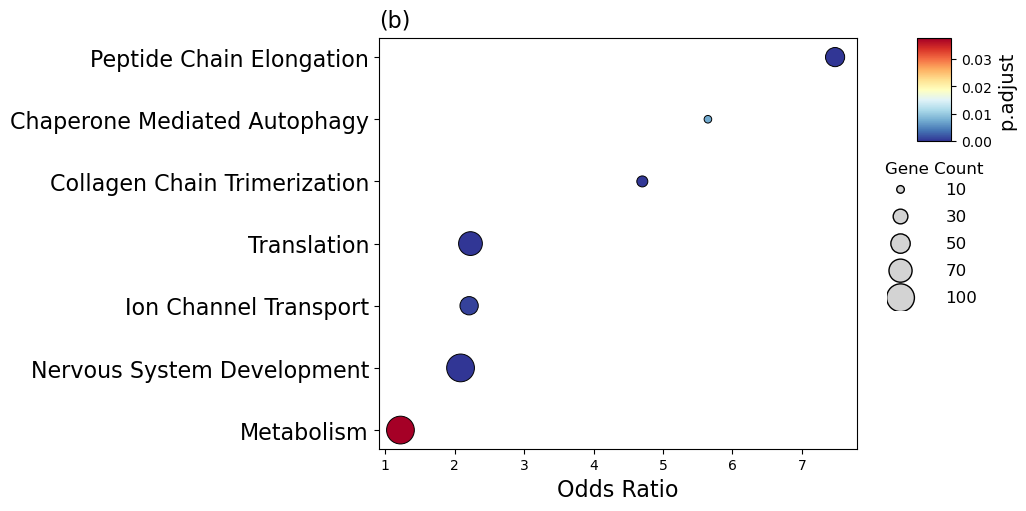

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# === Load ===
df = pd.read_csv("/home/fatemeh.nasrabadi/justperipathways.csv")

# GeneCount from semicolon-separated list
df["Genes"] = df["Genes"].fillna("")
df["GeneCount"] = df["Genes"].apply(lambda s: 0 if s.strip() == "" else s.count(";") + 1)

# Numeric
df["Adjusted P-value"] = pd.to_numeric(df["Adjusted P-value"], errors="coerce")
df["Odds Ratio"]       = pd.to_numeric(df["Odds Ratio"], errors="coerce")

# ---- SORT EVERYTHING by highest Odds Ratio (top→bottom) ----
df_sorted = df.sort_values("Odds Ratio", ascending=False).reset_index(drop=True)
df_sorted["Term"] = pd.Categorical(df_sorted["Term"],
                                   categories=df_sorted["Term"], ordered=True)

# ==== Figure with separate legend column ====
fig = plt.figure(figsize=(10,5), constrained_layout=True)
gs  = GridSpec(nrows=1, ncols=2, width_ratios=[0.78, 0.22], figure=fig)

ax = fig.add_subplot(gs[0, 0])       # main plot
ax_right = fig.add_subplot(gs[0, 1]) # legend column
ax_right.axis("off")

# --- Bubble sizes mapped to 10–100 genes (smaller overall scale) ---
size_min, size_max = 10, 100
smin, smax = 30, 400   # reduced size range (was 80–900)
sizes = np.interp(df_sorted["GeneCount"], [size_min, size_max], [smin, smax])

# === Scatter ===
pts = ax.scatter(
    x=df_sorted["Odds Ratio"],
    y=df_sorted["Term"],
    s=sizes,
    c=df_sorted["Adjusted P-value"],
    cmap="RdYlBu_r",
    edgecolor="black",
    linewidth=0.7
)

# Put the first category (largest odds ratio) at the TOP
ax.invert_yaxis()
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel("Odds Ratio", fontsize=16)
ax.set_ylabel("")
ax.set_title("(b)", fontsize=16, pad=8,loc="left")

# === p.adjust colorbar (kept same proportions, slightly smaller) ===
ax_cbar = inset_axes(ax_right, width="25%", height="25%",  # reduced height
                     loc="upper center", borderpad=0)
cbar = fig.colorbar(pts, cax=ax_cbar, orientation="vertical")
cbar.set_label("p.adjust", fontsize=14)

# === Size legend (smaller circles, adjusted limits) ===
ax_size = inset_axes(ax_right, width="70%", height="33%", loc="center", borderpad=0)

size_ticks = [10, 30, 50, 70, 100]
size_marker = np.interp(size_ticks, [size_min, size_max], [smin, smax])

ypos = np.arange(len(size_ticks))[::-1]
x_mark = 0.5
ax_size.scatter(np.full_like(ypos, x_mark), ypos, s=size_marker,
                c="lightgray", edgecolors="black")

for y, lab in zip(ypos, size_ticks):
    ax_size.text(x_mark + 0.5, y, f"{lab}", va="center", fontsize=12)

ax_size.set_title("Gene Count", fontsize=12, pad=2)
ax_size.set_xlim(-0.3, 1.8)
ax_size.set_ylim(-0.5, len(size_ticks)-0.5)
ax_size.axis("off")

plt.show()


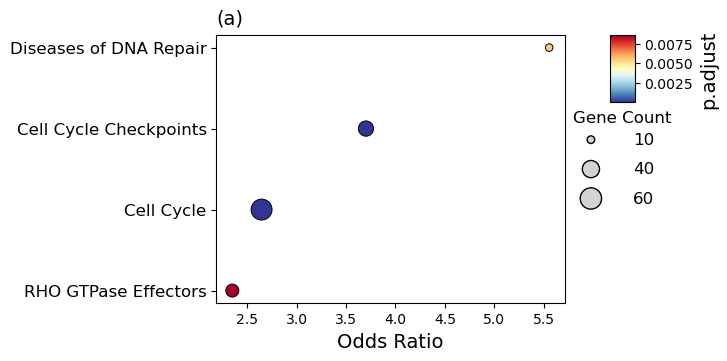

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# === Load ===
df = pd.read_csv("/home/fatemeh.nasrabadi/justcore.csv")

# GeneCount from semicolon-separated list
df["Genes"] = df["Genes"].fillna("")
df["GeneCount"] = df["Genes"].apply(lambda s: 0 if s.strip() == "" else s.count(";") + 1)

# Numeric
df["Adjusted P-value"] = pd.to_numeric(df["Adjusted P-value"], errors="coerce")
df["Odds Ratio"]       = pd.to_numeric(df["Odds Ratio"], errors="coerce")

# ---- SORT EVERYTHING by highest Odds Ratio (top→bottom) ----
df_sorted = df.sort_values("Odds Ratio", ascending=False).reset_index(drop=True)
df_sorted["Term"] = pd.Categorical(df_sorted["Term"],
                                   categories=df_sorted["Term"], ordered=True)
#3.5 8.5 works
# ==== Figure with separate legend column ====
fig = plt.figure(figsize=(6.70,3.5), constrained_layout=True)
gs  = GridSpec(nrows=1, ncols=2, width_ratios=[0.78, 0.22], figure=fig)

ax = fig.add_subplot(gs[0, 0])       # main plot
ax_right = fig.add_subplot(gs[0, 1]) # legend column
ax_right.axis("off")

# --- Bubble sizes mapped to 10–100 genes (smaller overall scale) ---
size_min, size_max = 10, 100
smin, smax = 30, 400   # reduced size range (was 80–900)
sizes = np.interp(df_sorted["GeneCount"], [size_min, size_max], [smin, smax])

# === Scatter ===
pts = ax.scatter(
    x=df_sorted["Odds Ratio"],
    y=df_sorted["Term"],
    s=sizes,
    c=df_sorted["Adjusted P-value"],
    cmap="RdYlBu_r",
    edgecolor="black",
    linewidth=0.7
)

# Put the first category (largest odds ratio) at the TOP
ax.invert_yaxis()
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel("Odds Ratio", fontsize=14)
ax.set_ylabel("")
ax.set_title("(a)", fontsize=14, pad=8,loc="left")

# === p.adjust colorbar (kept same proportions, slightly smaller) ===
ax_cbar = inset_axes(ax_right, width="25%", height="25%",  # reduced height
                     loc="upper center", borderpad=0)
cbar = fig.colorbar(pts, cax=ax_cbar, orientation="vertical")
cbar.set_label("p.adjust", fontsize=14)

# === Size legend (smaller circles, adjusted limits) ===
ax_size = inset_axes(ax_right, width="90%", height="33%", loc="center", borderpad=0)

size_ticks = [10, 40,60,]
size_marker = np.interp(size_ticks, [size_min, size_max], [smin, smax])

ypos = np.arange(len(size_ticks))[::-1]
x_mark = 0.5
ax_size.scatter(np.full_like(ypos, x_mark), ypos, s=size_marker,
                c="lightgray", edgecolors="black")

for y, lab in zip(ypos, size_ticks):
    ax_size.text(x_mark + 0.5, y, f"{lab}", va="center", fontsize=12)

ax_size.set_title("Gene Count", fontsize=12, pad=2)
ax_size.set_xlim(-0.3, 1.8)
ax_size.set_ylim(-0.5, len(size_ticks)-0.5)
ax_size.axis("off")

plt.show()
